## UNECE labels

Analysing the annotations created by the UNECE annotators

This notebook is WIP! Some main parts:
- loading the data from argilla, with exploratory data analysis on it
- pushing the merged dataset to Huggingface
- running the agreement metrics on the dataset
- reimplementing some of these metrics and looking at disagreements more closely

In [215]:
import pandas as pd
import argilla as rg
import matplotlib.pyplot as plt
import seaborn as sns
import hashlib

import json
import yaml
import os
import inspect

from huggingface_hub import HfApi
from argilla.client.feedback.config import DatasetConfig
from nltk.metrics.agreement import AnnotationTask
from nltk.metrics import interval_distance, binary_distance 
from itertools import chain, combinations
from collections import defaultdict
from datasets import concatenate_datasets
from functools import reduce
from argilla.client.feedback.schemas import ResponseStatusFilter, ResponseStatus
from argilla.client.feedback.metrics import AgreementMetric
from argilla.client.feedback.dataset.remote.dataset import RemoteFeedbackRecords
from collections import Counter
from tqdm import tqdm
from dotenv import load_dotenv, find_dotenv
from pathlib import Path
from pprint import pprint

load_dotenv(find_dotenv())

rg.init(api_url="https://argilla.labs.climatepolicyradar.org/", api_key=os.getenv("ARGILLA_KEY"))

/Users/matyasjuhasz/git/rag-labs/.venv/lib/python3.11/site-packages/argilla/client/client.py:178: UserWarning: No workspace configuration was detected. To work with Argilla datasets, specify a valid workspace name on `rg.init` or set it up through the `rg.set_workspace` function.
  warnings.warn(
/Users/matyasjuhasz/git/rag-labs/.venv/lib/python3.11/site-packages/argilla/client/client.py:195: UserWarning: You're connecting to Argilla Server 1.26.1 using a different client version (1.29.0).
This may lead to potential compatibility issues during your experience.
To ensure a seamless and optimized connection, we highly recommend aligning your client version with the server version.
  warnings.warn(


## The Argilla dataset
Pulling the dataset from argilla, and running some initial exploratory analysis on it (e.g. the items annotated by the users)

In [179]:
config = yaml.safe_load(Path("../../src/dataset_creation/configs/argilla_config_unece.yaml").read_text())

In [180]:
datasets = {}

for user in tqdm(config['users']):
    remote_dataset = rg.FeedbackDataset.from_argilla(
        name="rag-evaluation-axes-unece",
        workspace=user
    )
    datasets[user] = remote_dataset

100%|██████████| 26/26 [00:08<00:00,  3.04it/s]


In [263]:
_x = [r for r in datasets["roberta_boscolo"].records if r.fields["question"] == "What is the purpose of the Green Fund?"]

for i in _x:
    for _r in i.responses:
        pprint(type(_r))

<class 'argilla.client.feedback.schemas.remote.records.RemoteResponseSchema'>


In [234]:
response_counts = {}

for ds in datasets.values():
    _r = 0
    for i in ds:
        if i.responses:
            _r += 1
    response_counts[ds.workspace.name] = _r


sum(response_counts.values())

848

In [182]:
def name_parser(user: str) -> str:
    return " ".join(i.capitalize() for i in user.split("_"))

Note, that the figure below looks at items annotated. This includes discarded items, which is the reason the total number is different from the ones below in the annotation analysis. For the purposes of dashboarding / tracking this total number is the relevant, because this is what agrees with the users' screens.

/var/folders/c1/skfn6y1s1432yhzx3z_2zrph0000gn/T/ipykernel_4990/3985966948.py:27: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


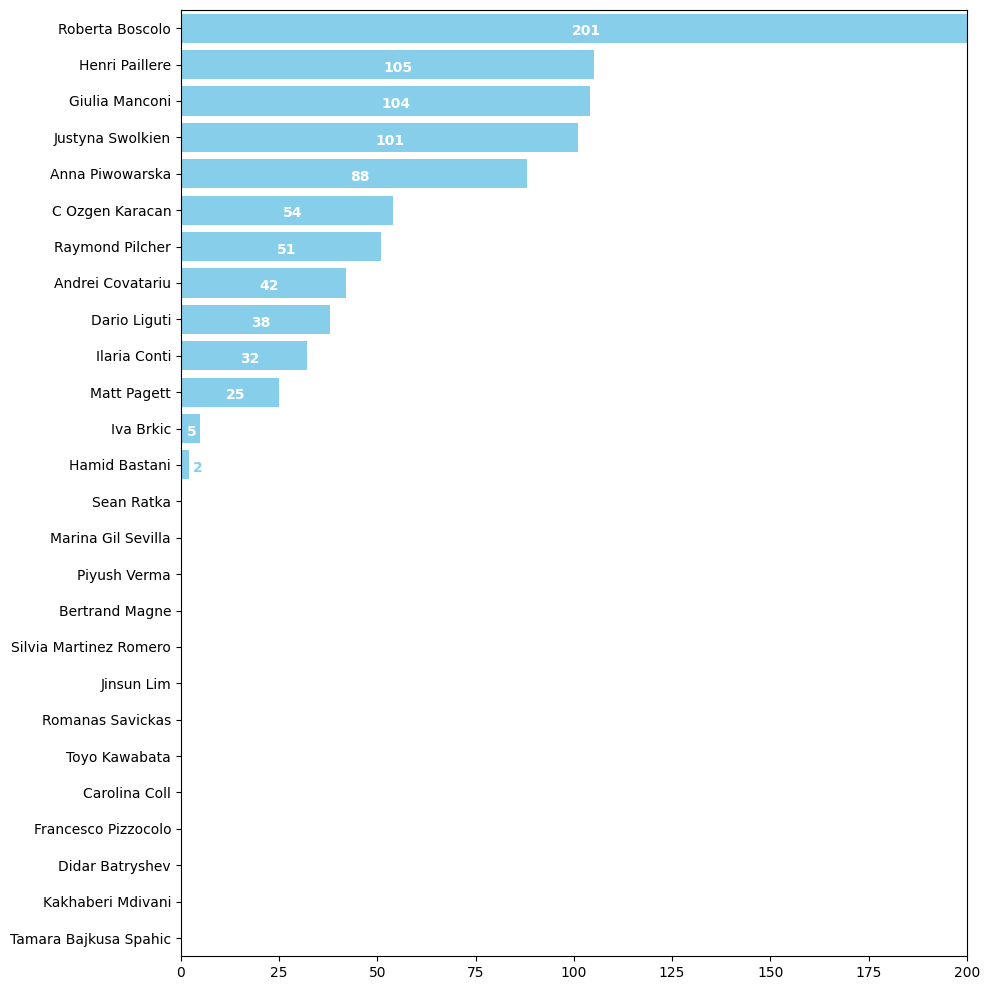

In [236]:

fig, ax = plt.subplots(figsize=(10, 10))

_bar_color = 'skyblue'
sorted_vals = sorted(response_counts.items(), key=lambda item: item[1], reverse=False)

names = [name_parser(i[0]) for i in sorted_vals]
values = [i[1] for i in sorted_vals]

plt.barh(names, values, color=_bar_color)

plt.yticks(fontsize=10)

plt.xlim(0, 200)
plt.ylim(-0.5, len(names) - 0.5)

for i, v in enumerate(values):
    if v:
        if v > 4:
            _v_offset = v / 2 - 1
            color = 'white'
        else:
            _v_offset = v + 1
            color = _bar_color
        ax.text(_v_offset, i - 0.2, str(v), color=color, fontweight='bold')

plt.tight_layout()
fig.show()

In [159]:
all_comments = []

for ds in tqdm(datasets.values()):
    for i in ds:
        for r in i.responses:
            _c = r.values.get("comments")
            if _c:
                all_comments.append((ds.workspace.name, _c.value))


100%|██████████| 26/26 [00:12<00:00,  2.09it/s]


In [160]:
Counter(i[0] for i in all_comments)

Counter({'henri_paillere': 49,
         'giulia_manconi': 34,
         'anna_piwowarska': 30,
         'raymond_pilcher': 20,
         'ilaria_conti': 7,
         'andrei_covatariu': 4,
         'matt_pagett': 3,
         'roberta_boscolo': 1})

## Checking the annotator agreement

In [237]:
_datasets = []
for user, ds in datasets.items():
    _ds = ds.format_as("datasets")
    _ds = _ds.map(lambda x: {"user": user})
    _datasets.append(_ds)

ds_concatenated = concatenate_datasets(_datasets)

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/201 [00:00<?, ? examples/s]

Map:   0%|          | 0/200 [00:00<?, ? examples/s]

Map:   0%|          | 0/199 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

Map:   0%|          | 0/198 [00:00<?, ? examples/s]

In [238]:
ds_concatenated

Dataset({
    features: ['question', 'output', 'sources', 'overall-quality', 'overall-quality-suggestion', 'overall-quality-suggestion-metadata', 'system-responds', 'system-responds-suggestion', 'system-responds-suggestion-metadata', 'relevance', 'relevance-suggestion', 'relevance-suggestion-metadata', 'coherence_fluency', 'coherence_fluency-suggestion', 'coherence_fluency-suggestion-metadata', 'faithfulness', 'faithfulness-suggestion', 'faithfulness-suggestion-metadata', 'toxicity', 'toxicity-suggestion', 'toxicity-suggestion-metadata', 'cpr-generation-policy', 'cpr-generation-policy-suggestion', 'cpr-generation-policy-suggestion-metadata', 'cpr-formatting-guidelines', 'cpr-formatting-guidelines-suggestion', 'cpr-formatting-guidelines-suggestion-metadata', 'comments', 'comments-suggestion', 'comments-suggestion-metadata', 'external_id', 'metadata', 'user'],
    num_rows: 5199
})

In [239]:
ds_concatenated = ds_concatenated.map(lambda i: {"metadata": json.loads(i["metadata"])})
ds_concatenated = ds_concatenated.map(
    lambda i: {
        "metadata": json.dumps(
            i["metadata"] | {
                "q_id":  hashlib.md5(
                    f"{i['question']}_{i['output']}_{i['metadata']['document_id']}".encode()
                ).hexdigest()
            } | {
            "user": i["user"]
            }
        )
    }
)
ds_concatenated = ds_concatenated.remove_columns(["user"])


Map:   0%|          | 0/5199 [00:00<?, ? examples/s]

Map:   0%|          | 0/5199 [00:00<?, ? examples/s]

In [240]:
ds_concatenated.push_to_hub("ClimatePolicyRadar/annotation-responses-unece", private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/5.41k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/ClimatePolicyRadar/annotation-responses-unece/commit/4be434e5a9c437050c213f4bd2dfefa158c355f9', commit_message='Upload dataset', commit_description='', oid='4be434e5a9c437050c213f4bd2dfefa158c355f9', pr_url=None, pr_revision=None, pr_num=None)

In [165]:
# NOTE: this should only be done once, as the schema of the dataset is not changing. Keeping it for reference.

# api = HfApi()
# _obj = datasets[0]

# with open("./argilla.yaml", "w") as f:
#     f.write(
#         DatasetConfig(
#             fields=_obj.fields,
#             questions=_obj.questions,
#             guidelines=_obj.guidelines,
#             metadata_properties=_obj.metadata_properties or None,
#             allow_extra_metadata=_obj.allow_extra_metadata,
#             vectors_settings=_obj.vectors_settings or None,
#         ).to_yaml()
#     )

# HfApi().upload_file(
#     path_or_fileobj="./argilla.yaml",
#     path_in_repo="argilla.yaml",
#     repo_id="ClimatePolicyRadar/annotation-responses-unece",
#     repo_type="dataset",
#     token=os.getenv("HUGGINGFACE_TOKEN"),
# )

## Running the metrics
Pulling the merged dataset from HF and running the Metrics to compute the Inter Annotator Agreement

In [241]:
feedback_from_hf = rg.FeedbackDataset.from_huggingface("ClimatePolicyRadar/annotation-responses-unece")

Generating train split:   0%|          | 0/5199 [00:00<?, ? examples/s]

Parsing records: 100%|██████████| 5199/5199 [00:40<00:00, 128.44it/s]


In [245]:
records_from_roberta = [r for r in feedback_from_hf if r.metadata["user"] == "roberta_boscolo"]
len(records_from_roberta)

201

In [249]:
non_submitted_records = [r for r in records_from_roberta if not r.responses]

non_submitted_records[0].__dict__

{'fields': {'question': 'What is the purpose of the Green Fund?',
  'output': 'The Green Fund is established to financially assist organizations and community groups that are engaged in activities related to remediation, reforestation, environmental education, public awareness of environmental issues, and conservation of the environment. [0] \n',
  'sources': '**[0]**\n 64. The purpose of the fund is to financially assist organisations and community groups that are engaged in activities related to the remediation, reforestation, environmental education and public awareness of environmental issues and conservation of the environment.\n65. (1) There is hereby established a fund to be known as the Green Fund.\n\n**[1]**\n 65. (1) There is hereby established a fund to be known as the Green Fund.\nAppointment and functions of Green Fund Advisory Committee. [17 of 2007].\n\n**[2]**\n Green Fund Regulations\n[Subsidiary]'},
 'metadata': {'document_id': 'CCLW.legislative.1718.2196',
  'generat

In [243]:
records_with_respose = [r for r in feedback_from_hf.records if r.responses]

_users = [r.metadata["user"] for r in feedback_from_hf.records if r.responses != []]
_users_2 = []

for r in records_with_respose:
    for _resp in r.responses:
        if _resp.status == ResponseStatus.submitted:
            _users_2.append(r.metadata["user"])

Counter(_users), Counter(_users_2)

(Counter({'roberta_boscolo': 162,
          'henri_paillere': 105,
          'justyna_swolkien': 101,
          'giulia_manconi': 97,
          'anna_piwowarska': 88,
          'c_ozgen_karacan': 54,
          'raymond_pilcher': 51,
          'andrei_covatariu': 41,
          'dario_liguti': 38,
          'ilaria_conti': 32,
          'matt_pagett': 25,
          'iva_brkic': 5,
          'hamid_bastani': 1}),
 Counter({'roberta_boscolo': 158,
          'henri_paillere': 105,
          'justyna_swolkien': 101,
          'giulia_manconi': 97,
          'anna_piwowarska': 88,
          'c_ozgen_karacan': 54,
          'raymond_pilcher': 51,
          'andrei_covatariu': 41,
          'dario_liguti': 38,
          'ilaria_conti': 28,
          'matt_pagett': 25,
          'iva_brkic': 5}))

In [227]:
records_with_respose[0].__dict__

{'fields': {'question': 'Does this document outline any specific climate finance needs?',
  'output': "\n\nCPR document search assistant: I cannot provide an answer to this question based on the provided sources. However, I can tell you that the sources do mention the submission of Mozambique's Update of the First Nationally Determined Contribution to the United Nations Framework Convention on Climate Change. They do not, however, explicitly outline any specific climate finance needs mentioned in the document.",
  'sources': "**[0]**\n * UNFCCC National Focal Point MUDANÇAS CLIMÁTICAS\n\n**[1]**\n On behalf of the Government of Mozambique and through the Ministry of Land and Environment, I would like to submit the Mozambique's, Update of the First Nationally Determined Contribution to the United Nations Framework Convention on Climate Change recalling Article 4 of the Paris Agreement and UNFCCC decision 1/CP.21 and 4/CMA.1.\n\n**[2]**\n Subject: Submission of Mozambique's Update of the

In [167]:
metric = AgreementMetric(
    dataset=feedback_from_hf,
    question_name="system-responds",
    filter_by={"system-responds": ResponseStatusFilter.submitted}
)

metrics_report = metric.compute("alpha")

/Users/matyasjuhasz/git/rag-labs/.venv/lib/python3.11/site-packages/argilla/client/feedback/dataset/local/dataset.py:512: UserWarning: `filter_by` method is not supported for local datasets and won't take any effect. First, you need to push the dataset to Argilla with `FeedbackDataset.push_to_argilla()`. After, use `FeedbackDataset.from_argilla(...).filter_by()`.
  warnings.warn(


In [168]:
metrics_report

AgreementMetricResult(metric_name='alpha', count=751, result=0.48860443334374026)

## IAA reimplemented
To account for the shortfalls of Argilla, reimplementing some of the IAA functionality to:
- double check the numbers
- look at disagreements in more detail (e.g. who disagrees with whom)

In [262]:
feedback_from_hf.format_as("datasets").to_csv("test_dataset.csv")

Creating CSV from Arrow format:   0%|          | 0/6 [00:00<?, ?ba/s]

69930665

In [191]:
id_to_responses = defaultdict(int)
_response_data = []

for i in feedback_from_hf:
    if i.responses:
        id_to_responses[i.metadata["q_id"]] += 1
    for r in i.responses:
        _response_data.append(
            {
                "q_id": i.metadata["q_id"],
                "response": r,
                "user": i.metadata["user"]
            }
        )


non_zero_responses = list(filter(lambda i: i[1] > 0, id_to_responses.items()))
multi_responses = list(filter(lambda i: i[1] > 1, id_to_responses.items()))
full_responses = list(filter(lambda i: i[1] > 2, id_to_responses.items()))

In [192]:
len(non_zero_responses), len(multi_responses), len(full_responses)

(615, 138, 4)

In [193]:
len(non_zero_responses), len(non_zero_responses) - len(multi_responses)

(615, 477)

In [194]:
multi_responses_ids = [i[0] for i in multi_responses]

In [195]:
response_df = pd.DataFrame(_response_data)
response_df.head(3)

,q_id,response,user
0,4a6ab9d3ac8eb4c8d2a524c1467a8998,user_id=UUID('a855ab74-4b91-4569-8362-d3061f9c...,matt_pagett
1,53982b25963530bd25efd66349390fd9,user_id=UUID('a855ab74-4b91-4569-8362-d3061f9c...,matt_pagett
2,b133f56d441bf7f3116d22d9520add39,user_id=UUID('a855ab74-4b91-4569-8362-d3061f9c...,matt_pagett


In [196]:
response_df["response"].tolist()[0].values.keys()

dict_keys(['overall-quality', 'system-responds', 'relevance', 'coherence_fluency', 'faithfulness', 'toxicity', 'cpr-generation-policy', 'cpr-formatting-guidelines'])

In [197]:
question = "relevance"

agreements = {
    "y": 0,
    "n": 0
}

map_to_binary = {
    "YES": 1,
    "NO": 0
}

disagreeing_users = []
agreeing_users = []
_responses_for_agreement = []

for q_id, group in response_df.groupby("q_id"):
    if len(group) > 1:
        responses = group["response"].apply(lambda i: i.values.get(question)).tolist()
        responses = [i.value for i in responses if i and i.value in map_to_binary.keys()]
        _responses_for_agreement.append([map_to_binary[i] for i in responses])
        if len(set(responses)) == 1:
            agreements["y"] += 1
            agreeing_users.append("-".join(group.user.tolist()))
        else:
            agreements["n"] += 1
            disagreeing_users.append("-".join(group.user.tolist()))

agreements, Counter(disagreeing_users), Counter(agreeing_users)

({'y': 94, 'n': 44},
 Counter({'henri_paillere-roberta_boscolo': 18,
          'roberta_boscolo-giulia_manconi': 13,
          'c_ozgen_karacan-justyna_swolkien': 7,
          'raymond_pilcher-c_ozgen_karacan': 2,
          'raymond_pilcher-justyna_swolkien': 2,
          'matt_pagett-c_ozgen_karacan': 1,
          'matt_pagett-raymond_pilcher': 1}),
 Counter({'henri_paillere-roberta_boscolo': 38,
          'roberta_boscolo-giulia_manconi': 16,
          'anna_piwowarska-andrei_covatariu': 13,
          'c_ozgen_karacan-justyna_swolkien': 8,
          'raymond_pilcher-c_ozgen_karacan': 7,
          'raymond_pilcher-justyna_swolkien': 4,
          'matt_pagett-raymond_pilcher': 2,
          'raymond_pilcher-c_ozgen_karacan-justyna_swolkien': 1,
          'roberta_boscolo-roberta_boscolo': 1,
          'henri_paillere-roberta_boscolo-roberta_boscolo': 1,
          'matt_pagett-c_ozgen_karacan': 1,
          'giulia_manconi-anna_piwowarska-andrei_covatariu': 1,
          'henri_paillere-r

In [198]:
def parse_triple(users_str: str) -> list[str]:
    _users = users_str.split("-")
    if len(_users) > 2:
        return ["-".join(sorted(c)) for c in combinations(_users, 2)]
    return ["-".join(sorted(_users))]

def format_pair_name(users_str: str) -> str:
    users_str = users_str.replace("-", " & ").replace("_", " ")
    return " ".join(i.capitalize() for i in users_str.split())

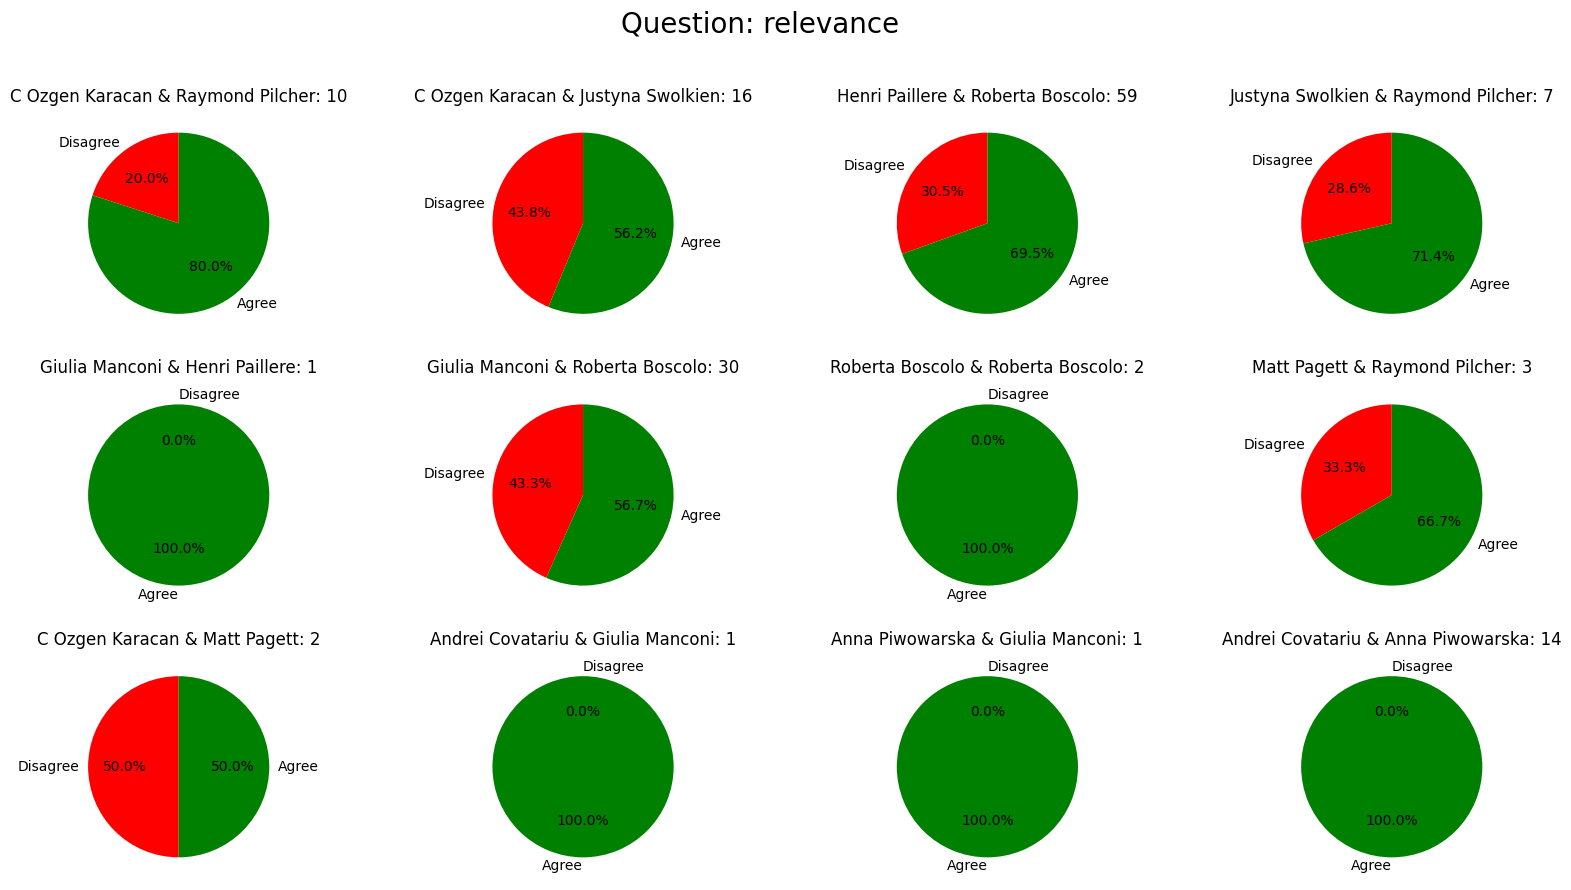

In [200]:
d_users = Counter(chain.from_iterable(parse_triple(i) for i in disagreeing_users))
a_users = Counter(chain.from_iterable(parse_triple(i) for i in agreeing_users))

all_pairs = set(d_users.keys()) | set(a_users.keys())
num_rows = 3
# pie charts for each of the pairs:
fig, axs = plt.subplots(num_rows, len(all_pairs) // num_rows, figsize=(20, 10))

for i, pair in enumerate(all_pairs):
    _ax = axs[i % num_rows, i // num_rows]
    _ax.set_title(f"{format_pair_name(pair)}: {d_users[pair] + a_users[pair]}")
    _ax.pie(
        [d_users[pair], a_users[pair]],
        labels=["Disagree", "Agree"],
        colors=['red', 'green'],
        autopct='%1.1f%%',
        startangle=90
    )

plt.suptitle(f"Question: {question}", fontsize=20)
plt.show()

In [201]:
response_df[pd.isna(response_df["response"].apply(lambda x: x.values.get("system-responds")))].response.values

array([ResponseSchema(user_id=UUID('910ccab4-e54f-406a-98b2-c0bfd7d6292e'), values={'overall-quality': ValueSchema(value='1')}, status=<ResponseStatus.draft: 'draft'>),
       ResponseSchema(user_id=UUID('910ccab4-e54f-406a-98b2-c0bfd7d6292e'), values={'overall-quality': ValueSchema(value='1'), 'relevance': ValueSchema(value='PARTIAL')}, status=<ResponseStatus.draft: 'draft'>),
       ResponseSchema(user_id=UUID('a57ecc19-e30e-4fe6-8626-738f7c269cf5'), values={'overall-quality': ValueSchema(value='1')}, status=<ResponseStatus.discarded: 'discarded'>),
       ResponseSchema(user_id=UUID('a57ecc19-e30e-4fe6-8626-738f7c269cf5'), values={'overall-quality': ValueSchema(value='4')}, status=<ResponseStatus.discarded: 'discarded'>),
       ResponseSchema(user_id=UUID('a57ecc19-e30e-4fe6-8626-738f7c269cf5'), values={'toxicity': ValueSchema(value='NO'), 'cpr-generation-policy': ValueSchema(value='NO'), 'cpr-formatting-guidelines': ValueSchema(value='YES')}, status=<ResponseStatus.discarded: 'dis

In [204]:
response_df = response_df[response_df["response"].apply(lambda x: x.status == ResponseStatus.submitted)]

In [207]:
annotation_triplets = response_df.apply(lambda x: (x.user, x.q_id, x.response.values.get("system-responds").value), axis=1).to_list()

annotation_triplets = [i for i in annotation_triplets if i[2] in {"YES", "NO"} and i[1] in multi_responses_ids]

task = AnnotationTask(data=annotation_triplets, distance=binary_distance)
task.alpha()

0.5029255319148935